#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [12]:
import pandas as pd

# To do linear algebra
import numpy as np
from numpy import pi

# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
# To create nicer plots
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To get new datatypes and functions
from collections import Counter
from cycler import cycler

from scipy.stats import norm,skew, probplot
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier

from time import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import itertools
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#load dataset
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

train_df['Data'] = 'Train'
test_df['Data'] = 'Test'

tt_df = pd.concat([train_df,test_df], axis = 0).reset_index(drop = True)


In [ ]:
#Check null values
train_df.isnull().values.any()
test_df.isnull().values.any()
# no null values in train and test data

In [ ]:
tt_df['subject'] = '#' + tt_df['subject'].astype(str)


In [ ]:
tt_df.shape

In [ ]:
tt_df.columns.values

In [ ]:
tt_df['Activity'].value_counts()

In [ ]:
label = tt_df.pop('Activity')

In [ ]:
train_df.head()

In [ ]:
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] 
                                for col in tt_df.columns]), 
                       orient = 'index').rename(columns = {0:'count'}).sort_values('count',ascending=False)


In [ ]:
print('Null values in DataFrme:{}\n'.format(tt_df.isna().sum().sum()))
tt_df.info()

In [ ]:
label_counts = label.value_counts()

n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0,1.01,1/(n-1))]

data = go.Bar(x = label_counts.index,
             y = label_counts,
             marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                  xaxis = dict(title = 'Activity'),
                  yaxis = dict(title = 'Count'))

fig = go.Figure(data = [data], layout=layout)
iplot(fig)

In [ ]:
tsne_data = tt_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

In [ ]:
#Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train,X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)

#Create the model
lgbm = LGBMClassifier(n_estimators = 500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Test the model
score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

In [ ]:
#Store the data
data = []
#Iterate over each activity
for activity in label_counts.index:
    #Create dataset
    act_data = tt_df[label==activity].copy()
    act_data_data = act_data.pop('Data')
    act_subject_data = act_data.pop('subject')
    
    #Scale data
    scl = StandardScaler()
    act_data = scl.fit_transform(act_data)
    
    #Reduce dimensions
    pca = PCA(n_components=0.9,random_state=3)
    act_data = pca.fit_transform(act_data)
    
    #Split training testing data
    enc = LabelEncoder()
    label_encoded = enc.fit_transform(act_subject_data)
    X_train,X_test,y_train,y_test = train_test_split(act_data, label_encoded,random_state=3)
    
    #Fit basic model
    print('Activity: {}'.format(activity))
    lgbm = LGBMClassifier(n_estimators=500,random_state=3)
    lgbm = lgbm.fit(X_train,y_train)
    
    score = accuracy_score(y_true=y_test, y_pred=lgbm.predict(X_test))
    print('Accuracy on testset: \t{:.4f}\n'.format(score))
    data.append([activity, score])

In [ ]:
#Create duration datafrae
duration_df = (tt_df.groupby([label,subject_data])['Data'].count().reset_index().groupby('Activity').agg({'Data':'mean'})*1.28).rename(columns = {'Data':'Seconds'})
activity_df = pd.DataFrame(data, columns=['Activity','Accuracy']).set_index('Activity')
activity_df.join(duration_df)

In [ ]:
# Create dataset
tsne_data = tt_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Split training testing data
enc = LabelEncoder()
label_encoded = enc.fit_transform(subject_data)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=3)


# Create model
lgbm = LGBMClassifier(n_estimators=500, random_state=3)
lgbm = lgbm.fit(X_train, y_train)

# Get importances
features = tt_df.drop(['Data', 'subject'], axis=1).columns
importances = lgbm.feature_importances_

# Sum importances
data = {'Gyroscope':0, 'Accelerometer':0}
for importance, feature in zip(importances, features):
    if 'Gyro' in feature:
        data['Gyroscope'] += importance
    if 'Acc' in feature:
        data['Accelerometer'] += importance
        
# Create dataframe and plot
sensor_df = pd.DataFrame.from_dict(data, orient='index').rename(columns={0:'Importance'})
sensor_df.plot(kind='barh', figsize=(14,4), title='Sensor Importance For Classifing Participants By Walking Style (Feature Importance Sum)')
plt.show()

How Long Does The Participant Use The Staircase?

In [ ]:
# Group the data by participant and compute total duration of staircase walking
mask = label.isin(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
duration_df = (tt_df[mask].groupby([label[mask], 'subject'])['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)
plot_data['Activity'] = plot_data['Activity'].map({'WALKING_UPSTAIRS':'Upstairs', 'WALKING_DOWNSTAIRS':'Downstairs'})

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data', hue='Activity')
plt.title('Participants Compared By Their Staircase Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

How Much Does The Up-/Downstairs Ratio Vary?

In [ ]:
# Create data and plot
plt.figure(figsize=(15,5))
plot_data = ((duration_df.loc['WALKING_UPSTAIRS'] / duration_df.loc['WALKING_DOWNSTAIRS']) -1).sort_values(ascending=False)
sns.barplot(x=plot_data.index, y=plot_data)
plt.title('By What Percentage Is The Participant Faster In Walking Downstairs Than Upstairs?')
plt.xlabel('Participants')
plt.ylabel('Percent')
plt.show()

Are There Conspicuities In The Staircase Walking Duration Distribution?

In [ ]:
def plotSkew(x):
    # Fit label to norm
    (mu, sigma) = norm.fit(x)
    alpha = skew(x)

    fig, axarr = plt.subplots(1, 2, figsize=(15,4))

    # Plot label and fit
    sns.distplot(x , fit=norm, ax=axarr[0])
    axarr[0].legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}, $\\alpha=$ {:.2f}'.format(mu, sigma, alpha)], loc='best')
    axarr[0].set_title('Staircase Walking Duration Distribution')
    axarr[0].set_ylabel('Frequency')

    # Plot probability plot
    res = probplot(x, plot=axarr[1])
    plt.show()
    
    
plotSkew(duration_df)

Is There A Unique Walking Style For Each Participant?

In [ ]:
fig, axarr = plt.subplots(5, 6, figsize=(15,6))

for person in range(0, 30):
    # Get data
    single_person = tt_df[(label=='WALKING') & (tt_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data = scl.fit_transform(single_person)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data = pca.fit_transform(tsne_data)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed = tsne.fit_transform(tsne_data)
    
    # Create plot
    axarr[person//6][person%6].plot(tsne_transformed[:,0], tsne_transformed[:,1], '.-')
    axarr[person//6][person%6].set_title('Participant #{}'.format(person+1))
    axarr[person//6][person%6].axis('off')
    
plt.tight_layout()
plt.show()

How Long Does The Participant Walk?

In [ ]:
# Group the data by participant and compute total duration of walking
mask = label=='WALKING'
duration_df = (tt_df[mask].groupby('subject')['Data'].count() * 1.28)

# Create plot
plot_data = duration_df.reset_index().sort_values('Data', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=plot_data, x='subject', y='Data')
plt.title('Participants Compared By Their Walking Duration')
plt.xlabel('Participants')
plt.ylabel('Total Duration [s]')
plt.show()

Is There A Unique Staircase Walking Style For Each Participant?

In [ ]:
# Create subplots
fig, axarr = plt.subplots(10, 6, figsize=(15,15))

# Iterate over each participant
for person in range(0, 30):
    # Get data
    single_person_up = tt_df[(label=='WALKING_UPSTAIRS') & (tt_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    single_person_down = tt_df[(label=='WALKING_DOWNSTAIRS') & (tt_df['subject']=='#{}'.format(person+1))].drop(['subject', 'Data'], axis=1)
    # Scale data
    scl = StandardScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)
    # Reduce dimensions
    pca = PCA(n_components=0.9, random_state=3)
    tsne_data_up = pca.fit_transform(tsne_data_up)
    tsne_data_down = pca.fit_transform(tsne_data_down)
    # Transform data
    tsne = TSNE(random_state=3)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    axarr[2*person//6][2*person%6].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.b-')
    axarr[2*person//6][2*person%6].set_title('Up: Participant #{}'.format(person+1))
    axarr[2*person//6][2*person%6].axis('off')
    axarr[2*person//6][(2*person%6)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.g-')
    axarr[2*person//6][(2*person%6)+1].set_title('Down: Participant #{}'.format(person+1))
    axarr[2*person//6][(2*person%6)+1].axis('off')
    
plt.tight_layout()
plt.show()

**Exploring Personal Information**


In [ ]:
# Get data
tsne_data = tt_df[label=='WALKING'].copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(1, 1, figsize=(15,10))

### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr.scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr.set_title('TSNE Walking Style By Participant')
plt.show()

**Modelling**

In [19]:
train_df=pd.read_csv("../input/train.csv")
test_df=pd.read_csv("../input/test.csv")

In [20]:
#subject col is not useful hence dropped
if('subject' in train_df.columns):
    train_df.drop('subject', axis=1, inplace=True)
if('subject' in test_df.columns):
    test_df.drop('subject', axis=1, inplace=True)


Variable Encoding for classes

In [21]:
# Encoding target - converting non-numto num variable
le = preprocessing.LabelEncoder()
for x in [train_df,  test_df]:
    x['Activity'] = le.fit_transform(x.Activity)

# Split into features and class
df_traindata, df_trainlabel = train_df.iloc[:,0:len(train_df.columns)-1],train_df.iloc[:,-1]
df_testdata, df_testlabel = test_df.iloc[:,0:len(test_df.columns)-1],test_df.iloc[:,-1]

In [22]:
df_trainlabel.value_counts()

0    1407
2    1374
1    1286
3    1226
5    1073
4     986
Name: Activity, dtype: int64

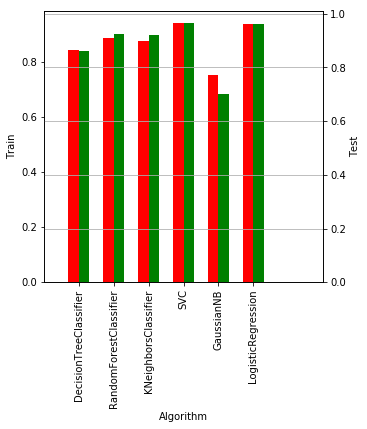

In [23]:
#Baseline Comparing model accuracy using all features accross classifiers
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    GaussianNB(),
    LogisticRegression()
    ]


# Naive Train Accuracy
algo = []
scores = []
for clf in classifiers:
    algo.append(clf.__class__.__name__)
    scores.append(cross_val_score(clf,df_traindata,df_trainlabel, cv=5).mean())
warnings.filterwarnings('ignore')
Naivescore_df_Train = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')


# Naive Test Accuracy

algo = []
scores = []

for clf in classifiers:
    clf = clf.fit(df_traindata, df_trainlabel)
    y_pred = clf.predict(df_testdata)
    algo.append(clf.__class__.__name__)
    scores.append(accuracy_score(y_pred, df_testlabel))
warnings.filterwarnings('ignore')
Naivescore_df_Test  = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

# Bar plot between Train and Test Accuracy
fig = plt.figure(figsize=(5,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

Naivescore_df_Train.Score.plot(kind='bar',color='green',ax=ax,width=width, position=0)
Naivescore_df_Test.Score.plot(kind='bar',color='red', ax=ax2,width = width,position=1)

ax.grid(None, axis=1)
ax2.grid(None)

ax.set_ylabel('Train')
ax2.set_ylabel('Test')

ax.set_xlim(-1,7)
plt.show()

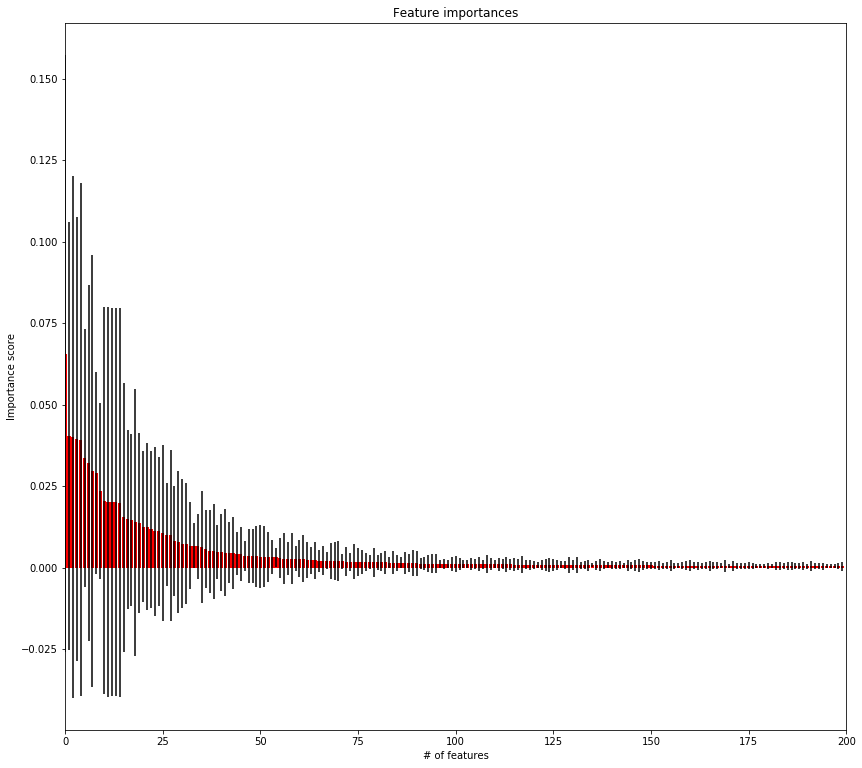

In [24]:
# Feature selection using Random Forest Classifer
# Bagged decision trees for feature importance - embedded method
Rtree_clf = RandomForestClassifier()
Rtree_clf = Rtree_clf.fit(df_traindata, df_trainlabel)
model = SelectFromModel(Rtree_clf,prefit = True)
RF_tree_featuresTrain = df_traindata.loc[:,model.get_support()]
RF_tree_featuresTest = df_testdata.loc[:,model.get_support()]

# Based on Feature Selection only 87 features were selected

# Feature Importance
# Important scores

importances = Rtree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
indices.shape
indices = indices[:200]

#Plot feature importances

plt.figure(1, figsize=(14,13))
plt.title('Feature importances')
plt.xlabel('# of features')
plt.ylabel('Importance score')
plt.bar(range(200), importances[indices],color='r',yerr=std[indices],align='center')
plt.xlim([0,200])
plt.show()

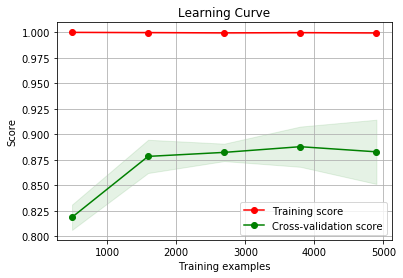

In [25]:
skplt.estimators.plot_learning_curve(Rtree_clf,RF_tree_featuresTrain,df_trainlabel)

Optimal number of features : 22


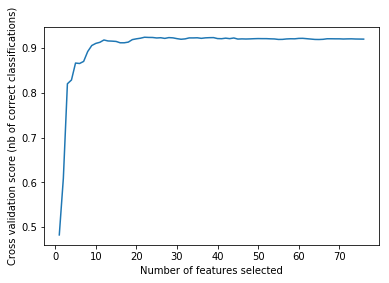

In [26]:
# Applying RFECV with svm classifier
svc=SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), # Stratified fold inorder to reduce bias
              scoring='accuracy')
rfetrain=rfecv.fit(RF_tree_featuresTrain, df_trainlabel)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [28]:
#ApplyingRFE with optimal number of features
rfe = RFE(estimator=svc, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(RF_tree_featuresTrain, df_trainlabel)

rfe_train=RF_tree_featuresTrain.loc[:,rfe.get_support()]
rfe_test=RF_tree_featuresTest.loc[:,rfe.get_support()]

#Checking the Accuracy after rfe
# Train Accuracy
print("Train Accuracy:", cross_val_score(svc,rfe_train,df_trainlabel, cv=5).mean())
#Test Accuracy
scv = svc.fit(rfe_train,df_trainlabel)
y_pred = svc.predict(rfe_test)
print('Test Accuracy:', accuracy_score(y_pred,df_testlabel))

Train Accuracy: 0.9189384512461697
Test Accuracy: 0.9005768578215134


Applying Variance Threshold method to remove low variance variable

In [31]:
# Variance threshold
selector = VarianceThreshold(0.95*(1-.95))
varsel=selector.fit(rfe_train)
rfe_train.loc[:,varsel.get_support()].shape
# 55
vartrain = rfe_train.loc[:, varsel.get_support()]
vartest = rfe_test.loc[:,varsel.get_support()]

#Checking the Accuracy after Variance threshold
# Train Accuracy
print('Train Accuracy:',cross_val_score(svc,vartrain,df_trainlabel,cv=5).mean())

# Test Accuracy
scv = svc.fit(vartrain, df_trainlabel)
y_pred = scv.predict(vartest)
print("Test Accuracy:", accuracy_score(y_pred, df_testlabel))

Train Accuracy: 0.9179837592642718
Test Accuracy: 0.9015948422124194


Dimension Reduction using PCA (Principal Component Analysis)

Text(0,0.5,'cumulative explained variance')

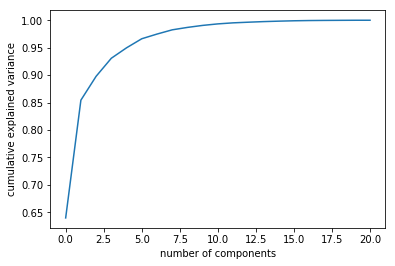

In [32]:
# PCA
pca = PCA(n_components=len(vartrain.columns))
pca_traindata = pca.fit(vartrain)

pca_traindata.explained_variance_
pca_traindata.n_components_
pcatrain = pca_traindata.transform(vartrain)
pcatest = pca_traindata.transform(vartest)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

# Visualize PCA result
plt.plot(np.cumsum(pca_traindata.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Applying PCA with number of components=21

In [33]:
# 21 features - constant after that
pca = PCA(n_components = 21)
pca_traindata = pca.fit(vartrain)

pca_traindata.explained_variance_
pca_traindata.n_components_
pcatrain = pca_traindata.transform(vartrain)
pcatest = pca_traindata.transform(vartest)
(np.cumsum(pca_traindata.explained_variance_ratio_))

array([0.63961628, 0.85429066, 0.89778722, 0.93072273, 0.9497401 ,
       0.96625916, 0.9747811 , 0.98251064, 0.98693183, 0.99058803,
       0.99335909, 0.99524604, 0.99643514, 0.99751985, 0.99833942,
       0.99902168, 0.99945487, 0.99968903, 0.99984869, 0.99998314,
       1.        ])

Visualizing top 2 principal components in scatter plot with data points segregated based on their activities

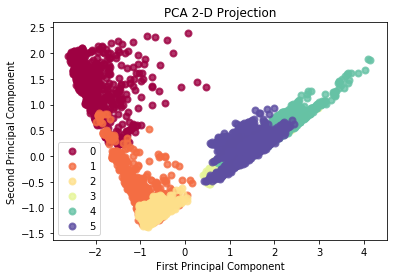

In [34]:
# PCA in 2D projection
skplt.decomposition.plot_pca_2d_projection(pca,vartrain,df_trainlabel)

Accuracy check on Test and Train to see if it has increased

In [35]:
# Checking Accuracy after applying PCA

# Train Accuracy
print('Train Accuracy:',cross_val_score(svc,pcatrain,df_trainlabel,cv=5).mean())

# Test Accuracy
scv = svc.fit(pcatrain, df_trainlabel)
y_pred = scv.predict(pcatest)
ac_score = accuracy_score(y_pred, df_testlabel)
print('Test Accuracy:', accuracy_score(y_pred,df_testlabel))

Train Accuracy: 0.9179837592642718
Test Accuracy: 0.9015948422124194


Confusion Matrix after applying PCA

Accuracy: 0.901595
Confusion matrix, without normalization
[[537   0   0   0   0   0]
 [  0 379 112   0   0   0]
 [  0  61 471   0   0   0]
 [  0   0   0 485   5   6]
 [  0   0   0   6 380  34]
 [  0   0   0  54  12 405]]


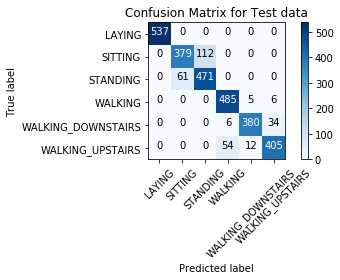

In [37]:
# Confusion Matrixf
cf_mat = confusion_matrix(df_testlabel,y_pred)
print('Accuracy: %f' %ac_score)
activities = le.classes_

#Plotting Confusion matrix heatmap
def plot_confusion_matrix(cm,classes, normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cf_mat, classes=activities,title="Confusion Matrix for Test data")

Hyper Parameter Tuning- finding the best parameters and kernel

In [38]:
# Parameter Tuning 

# Perfromance tuning using GridScore
param_grid = [
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = SVC()
clf = GridSearchCV(svr, param_grid,cv=5)
clf.fit(pcatrain,df_trainlabel)
print(clf.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


Train Test Accuracy check with best params and features

In [40]:
svr = SVC(kernel="rbf",C=1000,gamma=0.001)
print("Train Accuracy:",cross_val_score(svr,pcatrain,df_trainlabel, cv=5).mean())
# Test Accuracy
scv = svr.fit(pcatrain, df_trainlabel)
y_pred = scv.predict(pcatest)
print("Test Accuracy:",accuracy_score(y_pred, df_testlabel))

Train Accuracy: 0.9179820064549281
Test Accuracy: 0.9012555140821175


With test and train accuracy almost equal to 90%, we are getting a maximum accuracy at this level.